# Analyze results

In [16]:
import pandas as pd
import sqlite3
import seaborn as sns

# Charger electricity flows by time of day
- Table: OutputFlowOut
- Query: tech contains T_HDV_T_LH_CHRG_
- Groupby: period, season, tod, tech
- Agg: sum(flow)

Conclusion: electricity flows by time of day follow profiles in CapacityFactorTech

In [30]:
db_path = 'canoe_on_12d_baseline_newtech_simplemiddaypeak_solved.sqlite'
try:
    conn = sqlite3.connect(db_path)
    df_flow = pd.read_sql("SELECT * FROM OutputFlowOut", con=conn)
    df_netcapacity = pd.read_sql("SELECT * FROM OutputNetCapacity", con=conn)
    df_cap2act = pd.read_sql("SELECT * FROM CapacityToActivity", con=conn)

    df = (df_flow
          .merge(df_netcapacity[['tech', 'period', 'vintage', 'capacity']], how='left')
          .merge(df_cap2act[['tech', 'c2a']], how='left'))
    
finally: 
    if conn: conn.close()

In [59]:
plot_df = (df.query('tech.str.contains("T_HDV_T_LH_CHRG|T_H2_HDV_T_LH")')
 .query('season=="D007"')
 .query('period==2050')
 .groupby(['period', 'season', 'tod', 'tech'])
 .agg({'flow': 'sum', 'capacity': 'sum', 'c2a': 'mean'}).reset_index()
 .assign(capacityfactor = lambda x: x['flow'] / (x['capacity']*x['c2a']))
 )

In [60]:
plot_df

,period,season,tod,tech,flow,capacity,c2a,capacityfactor
0,2050,D007,H02,T_HDV_T_LH_CHRG_ERDS1,0.000270,838.849561,0.036925,0.000009
1,2050,D007,H02,T_HDV_T_LH_CHRG_ERDS2,0.000100,838.866873,0.013693,0.000009
2,2050,D007,H02,T_HDV_T_LH_CHRG_ERDS3,0.000080,2499.422224,0.003662,0.000009
3,2050,D007,H02,T_HDV_T_LH_CHRG_ERDS4,0.000043,3555.335337,0.001391,0.000009
4,2050,D007,H02,T_HDV_T_LH_CHRG_FSTCHRG,0.000737,5347.198440,0.094608,0.000001
...,...,...,...,...,...,...,...,...
125,2050,D007,H23,T_HDV_T_LH_CHRG_ERDS1,0.000270,838.849561,0.036925,0.000009
126,2050,D007,H23,T_HDV_T_LH_CHRG_ERDS2,0.000100,838.866873,0.013693,0.000009
127,2050,D007,H23,T_HDV_T_LH_CHRG_ERDS3,0.000080,2499.422224,0.003662,0.000009
128,2050,D007,H23,T_HDV_T_LH_CHRG_ERDS4,0.000043,3555.335337,0.001391,0.000009


In [61]:
plot_df.groupby('tech').capacityfactor.mean()

tech
T_HDV_T_LH_CHRG_ERDS1      0.000240
T_HDV_T_LH_CHRG_ERDS2      0.000240
T_HDV_T_LH_CHRG_ERDS3      0.000240
T_HDV_T_LH_CHRG_ERDS4      0.000240
T_HDV_T_LH_CHRG_ERDS5      0.000263
T_HDV_T_LH_CHRG_FSTCHRG    0.000040
Name: capacityfactor, dtype: float64

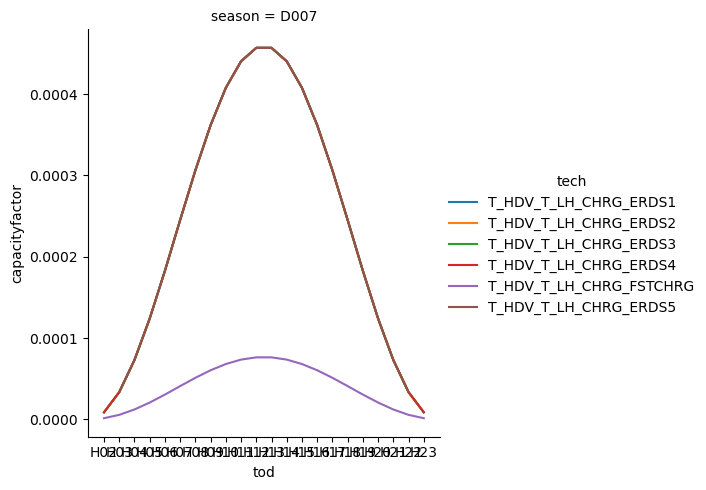

In [62]:
sns.relplot(plot_df, kind='line', x='tod', y='capacityfactor', hue='tech', row='season')